<a href="https://colab.research.google.com/github/MyNameIsEldar/Movie_Recommender/blob/main/rec_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#🎥Movie Recommender
Recommendation System using deep learning

##✔️Introduction

Required to build embeddings for each user and movie using **neural networks methods**. These embeddings will be used to find more relevant films for user.

I found [this work](https://arxiv.org/abs/1708.05031) implementing Neural Collaborative Filtering (NCF) for solving recommendation task. So I decided to use this method in my work.

For this task I will use the **full MovieLens 27M dataset**.


##📑Imports

In [2]:
import numpy as np
import pandas as pd
import os
from tqdm.notebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import mean_squared_error, roc_auc_score

## 💾Read The Data 

In [8]:
# Download the data from link
!wget https://files.grouplens.org/datasets/movielens/ml-latest.zip
!unzip ml-latest.zip

--2023-05-10 06:59:04--  https://files.grouplens.org/datasets/movielens/ml-latest.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 277113433 (264M) [application/zip]
Saving to: ‘ml-latest.zip’

ml-latest.zip       100%[===================>] 264.28M  28.6MB/s    in 9.9s    

2023-05-10 06:59:15 (26.6 MB/s) - ‘ml-latest.zip’ saved [277113433/277113433]

Archive:  ml-latest.zip
   creating: ml-latest/
  inflating: ml-latest/links.csv     
  inflating: ml-latest/tags.csv      
  inflating: ml-latest/genome-tags.csv  
  inflating: ml-latest/ratings.csv   
  inflating: ml-latest/README.txt    
  inflating: ml-latest/genome-scores.csv  
  inflating: ml-latest/movies.csv    


In [3]:
PATH = '/content/ml-latest/'

In [26]:
ratings = pd.read_csv(PATH+'ratings.csv')
genome_scores = pd.read_csv(PATH+'genome-scores.csv')
genome_tags = pd.read_csv(PATH+'genome-tags.csv')
links = pd.read_csv(PATH+'links.csv')
movies = pd.read_csv(PATH+'movies.csv')
tags = pd.read_csv(PATH+'tags.csv')

In [27]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264


In [28]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27753444 entries, 0 to 27753443
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 847.0 MB


27M is too big dataset for working with. So I will use only 10% of them

In [29]:
rand_userIds = np.random.choice(ratings['userId'].unique(), 
                                size=int(len(ratings['userId'].unique())*0.1), 
                                replace=False)

ratings = ratings.loc[ratings['userId'].isin(rand_userIds)]

print('There are {} rows of data from {} users'.format(len(ratings), len(rand_userIds)))

There are 5507318 rows of data from 56645 users


##📊EDA

The dataset has :

* tag.csv : that contains tags applied to movies by users
* rating.csv : that contains ratings of movies by users
* movie.csv : that contains movie information
* link.csv : that contains identifiers that can be used to link to other sources
* genome_scores.csv : that contains movie-tag relevance data
* genome_tags.csv : that contains tag descriptions



Ratings data will be enough for embedding task 

In [30]:
ratings.rating.value_counts()

4.0    1461818
3.0    1091496
5.0     812917
3.5     677041
4.5     475238
2.0     365304
2.5     271672
1.0     174563
0.5      89085
1.5      88184
Name: rating, dtype: int64

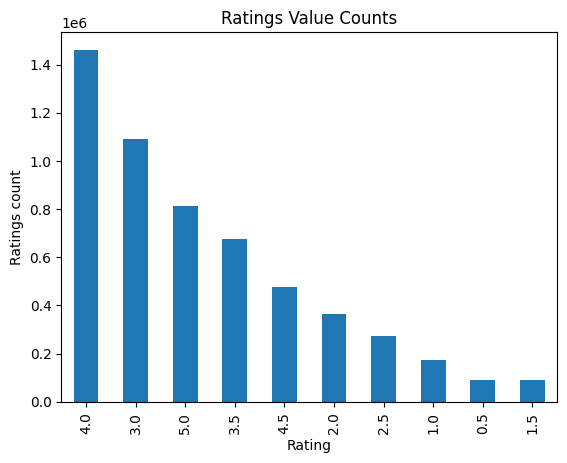

In [31]:
ratings.rating.value_counts().plot(kind='bar')
plt.title('Ratings Value Counts')
plt.ylabel('Ratings count')
plt.xlabel('Rating')
plt.show()

Most frequent rate is 4.0. Rather useres rate movies as 1.0, 0.5 and 1.5

In [32]:
print(f'There are {ratings.movieId.nunique()} unique films in data')

There are 35537 unique films in data


In [33]:
print(f'There are {ratings.userId.nunique()} unique users in data')

There are 56645 unique users in data


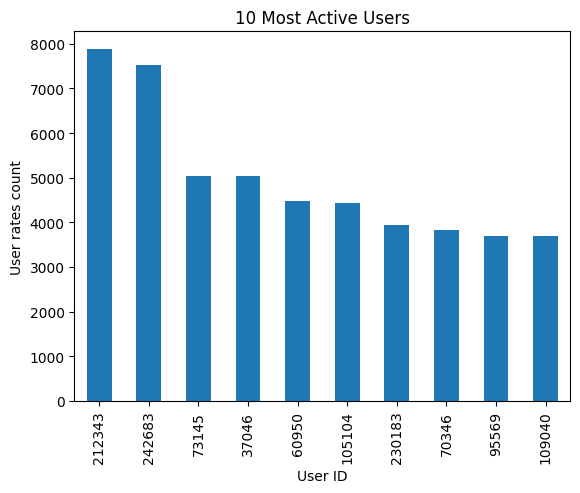

In [34]:
ratings.userId.value_counts()[:10].plot(kind='bar')
plt.title('10 Most Active Users')
plt.ylabel('User rates count')
plt.xlabel('User ID')
plt.show()

One user have more than **20 000** film rates! 

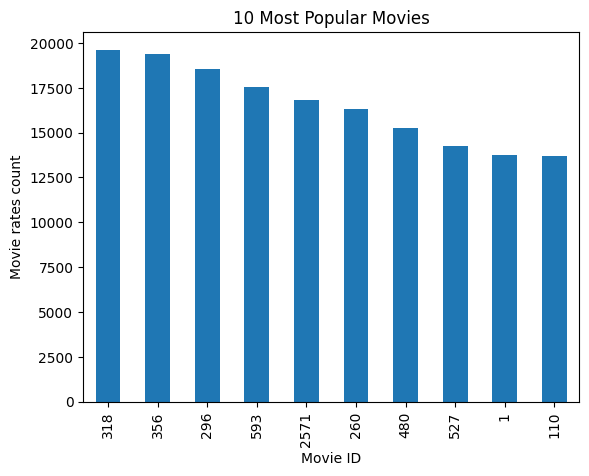

In [35]:
ratings.movieId.value_counts()[:10].plot(kind='bar')
plt.title('10 Most Popular Movies')
plt.ylabel('Movie rates count')
plt.xlabel('Movie ID')
plt.show()

Some of movies has about **100 000 rates**

In [36]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5507318 entries, 0 to 27752823
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 210.1 MB


In [37]:
# change dtype for timestamp
# ratings.timestamp = pd.to_datetime(ratings.timestamp, unit='s', origin='unix')
# ratings.head()

In [38]:
# ratings.info()

Is NA values in data?

In [39]:
ratings.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Is there any duplicates in data?

In [40]:
ratings.duplicated().sum()

0

## ⚙️Data Preproccesing

### Data Split

Along with the rating, there is also a timestamp column that shows the date and time the review was submitted. Using the timestamp column, we will implement our train-test split strategy. For each user, the most recent review is used as the test set, while the rest will be used as training data.

This train-test split strategy is often used when training and evaluating recommender systems. Doing a random split would not be fair, as we could potentially be using a user's recent reviews for training and earlier reviews for testing. This introduces data leakage with a look-ahead bias, and the performance of the trained model would not be generalizable to real-world performance.

The code below will split our ratings dataset into a train and test set.

In [41]:
ratings['rank_latest'] = ratings.groupby(['userId'])['timestamp'] \
                                .rank(method='first', ascending=False)

train_ratings = ratings[ratings['rank_latest'] != 1]
test_ratings = ratings[ratings['rank_latest'] == 1]

ratings.head(10)

,userId,movieId,rating,timestamp,rank_latest
0,1,307,3.5,1256677221,15.0
1,1,481,3.5,1256677456,8.0
2,1,1091,1.5,1256677471,5.0
3,1,1257,4.5,1256677460,7.0
4,1,1449,4.5,1256677264,10.0
5,1,1590,2.5,1256677236,14.0
6,1,1591,1.5,1256677475,4.0
7,1,2134,4.5,1256677464,6.0
8,1,2478,4.0,1256677239,13.0
9,1,2840,3.0,1256677500,1.0


In [42]:
train_ratings.head()

,userId,movieId,rating,timestamp,rank_latest
0,1,307,3.5,1256677221,15.0
1,1,481,3.5,1256677456,8.0
2,1,1091,1.5,1256677471,5.0
3,1,1257,4.5,1256677460,7.0
4,1,1449,4.5,1256677264,10.0


In [43]:
test_ratings.head()

,userId,movieId,rating,timestamp,rank_latest
9,1,2840,3.0,1256677500,1.0
1101,13,838,3.5,1413902093,1.0
1118,14,2,4.0,1522101105,1.0
1511,18,112,3.0,845061923,1.0
1782,19,798,3.0,850304644,1.0


In [44]:
# drop columns that we no longer need
train_ratings = train_ratings[['userId', 'movieId', 'rating']]
test_ratings = test_ratings[['userId', 'movieId', 'rating']]

Now we have splitted datasets and we will be able to evaluate model correctly

### Converting the dataset into an implicit feedback dataset

Our task - predict if user will watch that film or not. So we need to change target values. Now we have only ratings (numbers between 1 and 5) but we need class implict did user watch the film or not. Let's change ratings to 1.

In [45]:
train_ratings['target'] = 1
train_ratings.head()

<ipython-input-45-544ea949e0a2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_ratings['target'] = 1


,userId,movieId,rating,target
0,1,307,3.5,1
1,1,481,3.5,1
2,1,1091,1.5,1
3,1,1257,4.5,1
4,1,1449,4.5,1


Now we have problem - only positive (1) class. I will solve this problem just addtitng films that user didn't has watch

In [46]:
# Get a list of all movie IDs
all_movieIds = ratings['movieId'].unique()

# Placeholders that will hold the training data
users, items, labels = [], [], []

# This is the set of items that each user has interaction with
user_item_set = set(zip(train_ratings['userId'], train_ratings['movieId']))

In [47]:
user_item_set = set(zip(train_ratings['userId'], train_ratings['movieId']))
# 4:1 ratio of negative to positive samples
num_negatives = 4

for (u, i) in tqdm(user_item_set):
    users.append(u)
    items.append(i)
    labels.append(1) # items that the user has interacted with are positive
    for _ in range(num_negatives):
        # randomly select an item
        negative_item = np.random.choice(all_movieIds) 
        # check that the user has not interacted with this item
        while (u, negative_item) in user_item_set:
            negative_item = np.random.choice(all_movieIds)
        users.append(u)
        items.append(negative_item)
        labels.append(0) # items not interacted with are negative

  0%|          | 0/5450673 [00:00<?, ?it/s]

KeyboardInterrupt: ignored